In [13]:
import os
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
modelpath = Path.cwd() / '..' / 'results' / "basic_test" / "postnetworks"
datapath = Path.cwd() / ".." / ".." / "cluster_results" / "useful_networks"

In [88]:
nodal_caps = pd.read_csv(
    datapath / "expand_data" / "nodal_capacities.csv",
    index_col=[0,1,2],
    header=[0,1,2,3,4,5,6]
    )
print(nodal_caps.columns.get_level_values(6))

buses = nodal_caps.index.get_level_values(1).unique().dropna()
buses = buses[~buses.str.contains("EU")]
buses = buses[~buses.isin(['gas for', 'process', 'solid'])]

nodal_caps = nodal_caps.loc[:,buses,:,:]

idx = pd.IndexSlice

totals = nodal_caps.groupby(level=[0,1]).sum()

nodal_caps = nodal_caps.div(totals.reindex(nodal_caps.index, method='ffill'))

Index(['static', 'flex'], dtype='object', name='egs_op')


In [90]:
def show_correlation(operation):

    target = "geothermal heat elec"


    y = nodal_caps.loc[idx[:,:,target]].iloc[:,["static", "flex"].index(operation)]

    carriers = nodal_caps.index.get_level_values(2).unique().to_list()
    carriers.remove(target)

    X = nodal_caps.loc[idx[:,:,carriers]].iloc[:,0]
    # X.index = X.index.set_levels(X.index.get_level_values(0) + " " + X.index.get_level_values(2), level=2)
    # X.index = X.index.droplevel(0)

    # print(X)
    # X = X.unstack()

    buses = X.index.get_level_values(1).unique()

    X = pd.concat((
        X.loc[idx[:,bus,:]] for bus in buses
    ), axis=1)

    X.columns = buses
    y.index = buses
    X.index = X.index.get_level_values(1)

    _, ax = plt.subplots(1, 1, figsize=(8, 15)) 

    X.corrwith(y, axis=1).sort_values().plot.barh(ax=ax)
    ax.grid()

    plt.show()

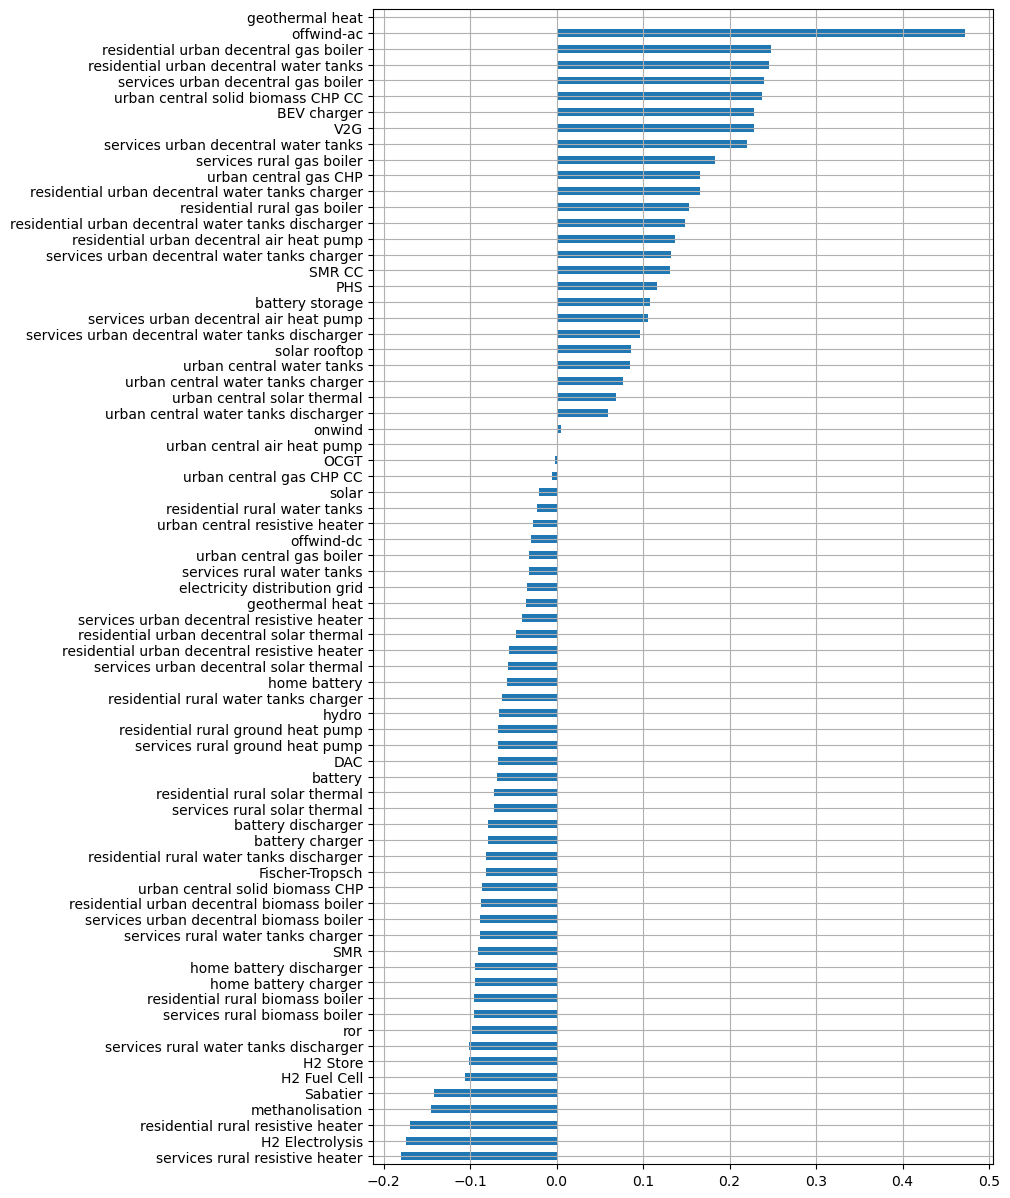

In [91]:
show_correlation("static")

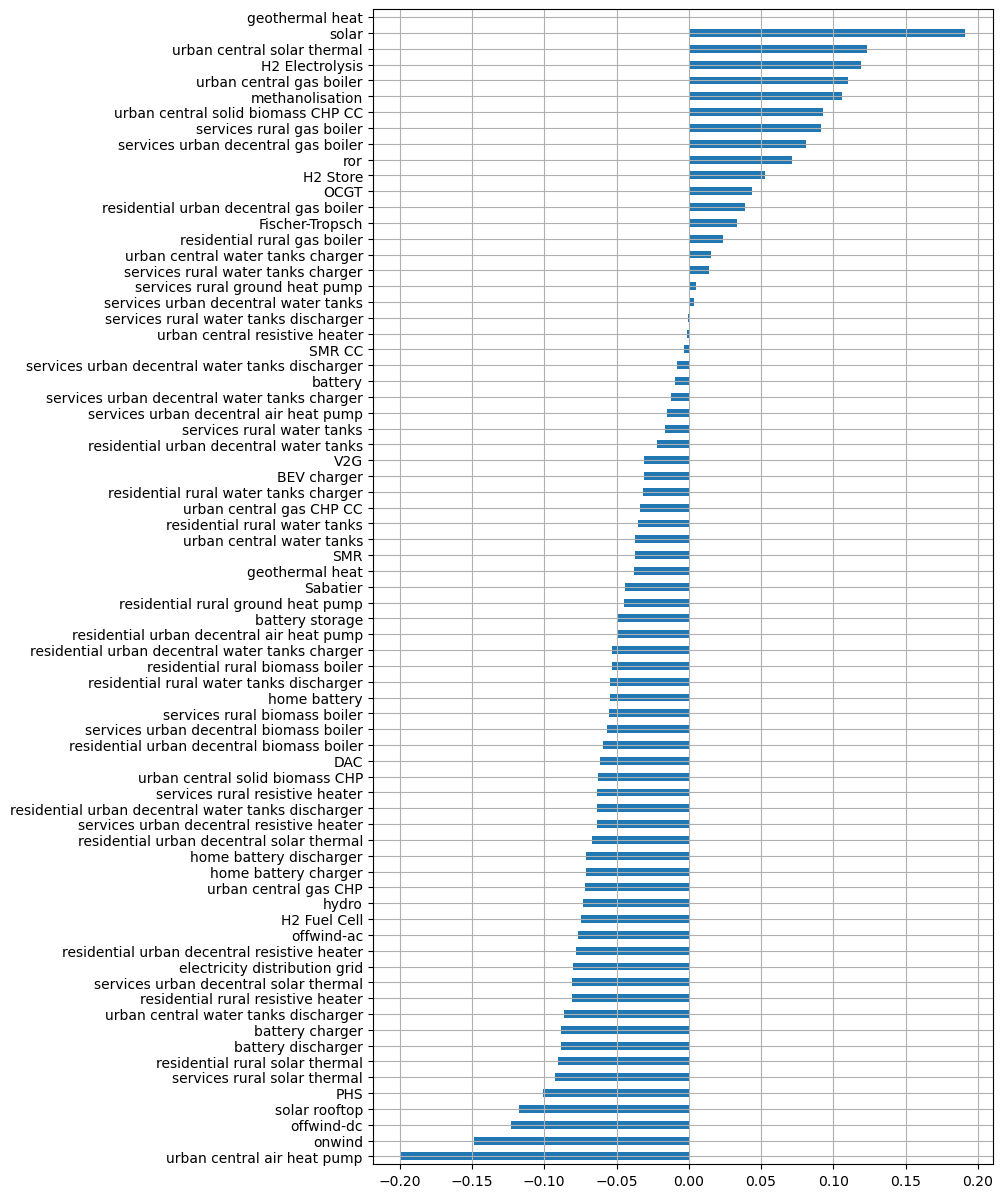

In [92]:
show_correlation("flex")

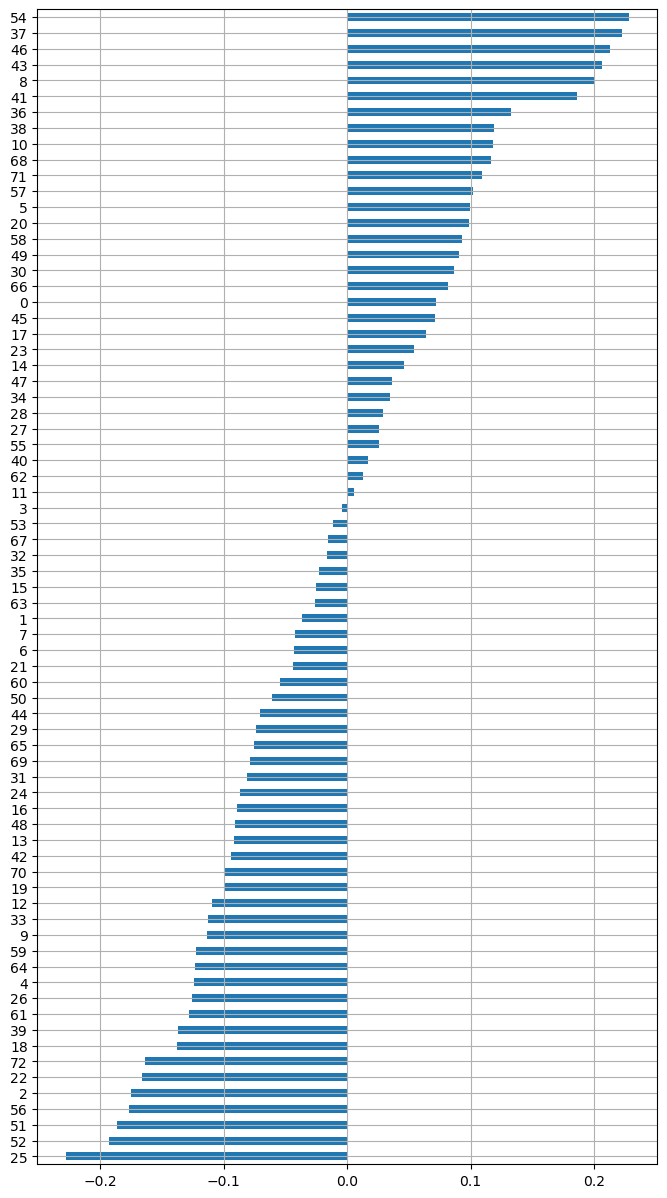

In [94]:
X = pd.DataFrame(np.random.normal(size=(73, 72)))
X.columns = y.index

_, ax = plt.subplots(1, 1, figsize=(8, 15)) 

X.corrwith(y, axis=1).sort_values().plot.barh(ax=ax)
ax.grid()

plt.show()

##### Based on new summaries

In [17]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pandas import IndexSlice

idx = IndexSlice

In [9]:
file = Path.cwd().parent.parent.parent / "cluster_data" / "joint data" / "nodal_geothermal_stats_1500_chp_dh.csv"

In [22]:
df = pd.read_csv(file, index_col=[0,1], header=[5,6]).fillna(0)

In [132]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [143]:
print(df.index.get_level_values(1).unique())

Index(['dac', 'geothermal generation share',
       'geothermal heat chp district heat', 'geothermal heat chp elec',
       'geothermal heat dh', 'offwind-ac', 'onwind', 'solar', 'offwind-dc'],
      dtype='object')


Index(['dac', 'geothermal generation share',
       'geothermal heat chp district heat', 'geothermal heat chp elec',
       'geothermal heat dh', 'offwind-ac', 'onwind', 'solar', 'offwind-dc'],
      dtype='object')


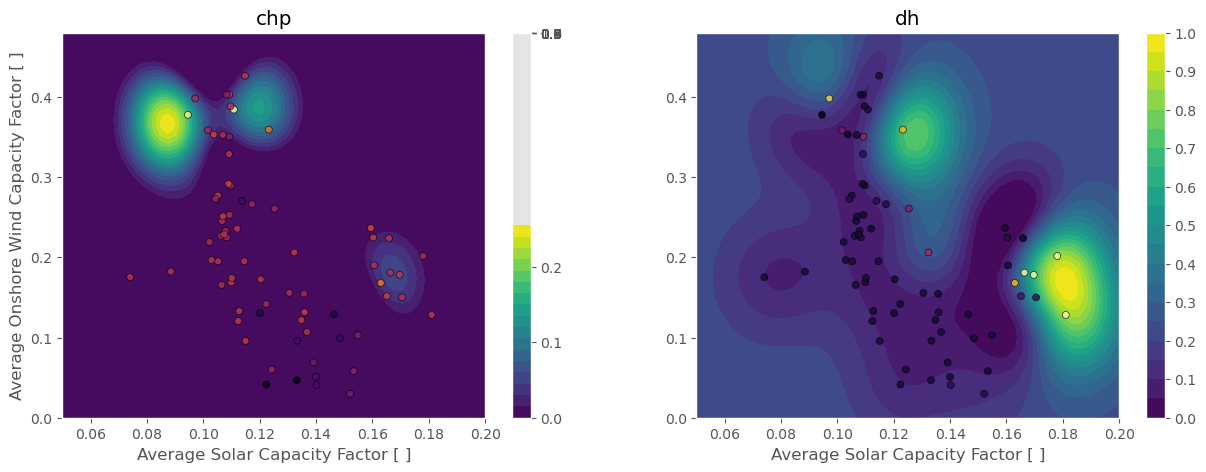

In [134]:
mode = "dh"

print(df.index.get_level_values(1).unique())

# quants = ["geothermal generation share", "dac", "onwind", "solar"]
# df.loc[idx[:, []], idx[mode]]
# df

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

scatter_kwargs = dict(
    s=25,
    alpha=0.8,
    edgecolors="k",
    cmap="inferno",
)

for ax, mode in zip(axs, ["dh", "chp"][::-1]):

    # model = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3)), n_restarts_optimizer=9)
    # model = GaussianProcessRegressor(kernel=C(1.0, (1e-3, 1e3)) * RBF(1.0, (0.25, 0.25)), n_restarts_optimizer=9)
    model = SVR(gamma=2, C=1)

    wind = df.loc[idx[:, ["onwind"]], idx[mode, "flex"]]
    solar = df.loc[idx[:, ["solar"]], idx[mode, "flex"]]

    diff = df.loc[idx[:, "geothermal generation share"], idx[mode, "flex"]] - df.loc[idx[:, "geothermal generation share"], idx[mode, "static"]]

    ax.set_xlabel("Average Solar Capacity Factor [ ]")

    X = np.vstack((solar.values, wind.values)).T

    scaler = StandardScaler()

    y = diff.values.flatten()



    model = model.fit(scaler.fit_transform(X), y)

    n = 400
    plot_x = np.linspace(0., 1., n)
    plot_y = np.linspace(0., 1., n)

    plot_x, plot_y = np.meshgrid(plot_x, plot_y)

    plot_x = plot_x.flatten()
    plot_y = plot_y.flatten()

    plot_X = np.vstack((plot_x, plot_y)).T

    plot_z = model.predict(scaler.transform(plot_X))

    plot_x = plot_X[:,0]
    plot_y = plot_X[:,1]

    plot_x = plot_x.reshape(n, n)
    plot_y = plot_y.reshape(n, n)
    plot_z = plot_z.reshape(n, n)

    cbar = ax.contourf(
        plot_x,
        plot_y,
        plot_z.clip(0., 1.),
        cmap="viridis",
        # vmin=0.,
        # vmax=1.,
        levels=20,
        # alpha=0.5
        )
    # ax.clabel(cbar)
    cbar = fig.colorbar(cbar, ax=ax)#, vmin=0., vmax=1.)
    v = np.linspace(0., 1., 11, endpoint=True)
    cbar.set_ticks(v)

    # ax.clabel(cbar, inline=True, fontsize=8)
    # ax.contourf(plot_x, plot_y, plot_y, cmap="plasma")

    ax.scatter(solar, wind, c=diff, **scatter_kwargs)
    ax.set_xlim(0.05, 0.2)
    ax.set_ylim(0.0, 0.48)

    ax.set_title(mode)

# plt.colorbar(cax=)

    # break

# for ax in axs:
# ax.legend()

axs[0].set_ylabel("Average Onshore Wind Capacity Factor [ ]")

plt.show()





<AxesSubplot:xlabel='location'>

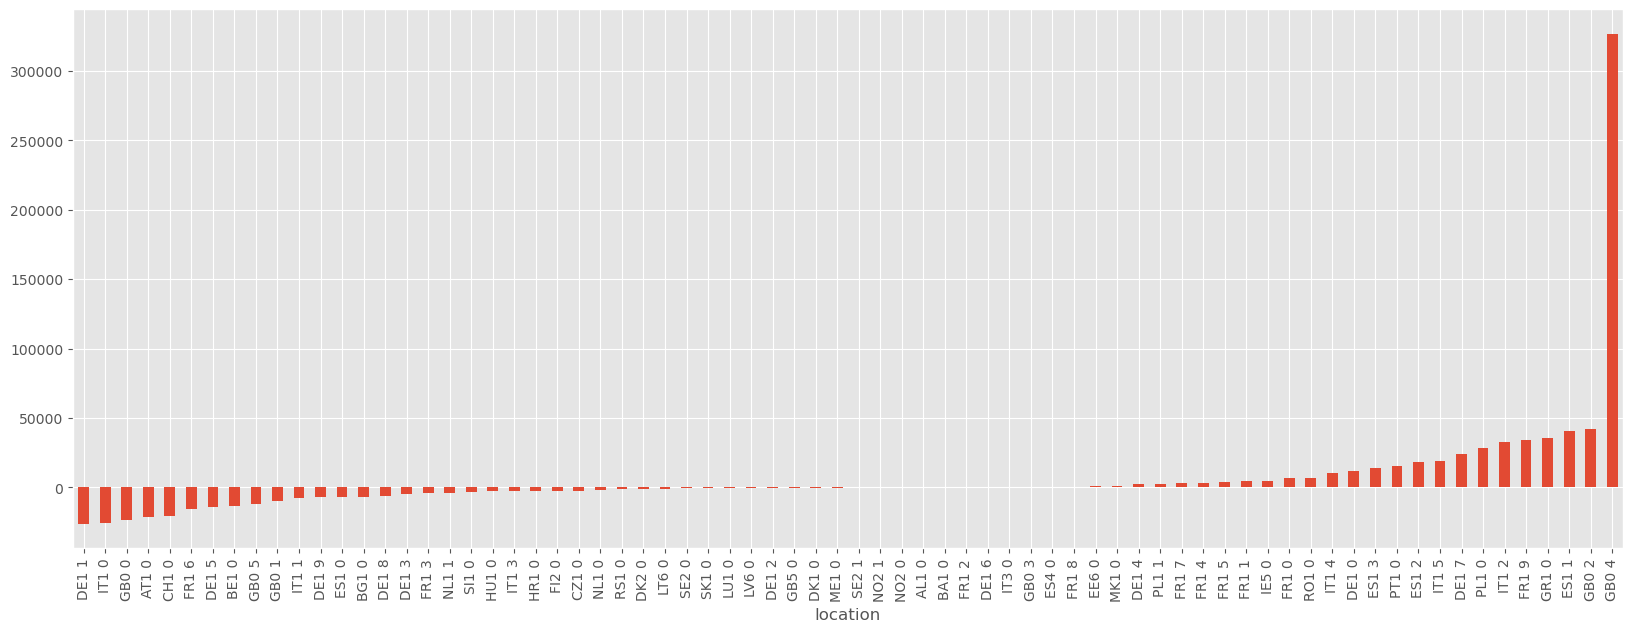

In [147]:
mode = "chp"

quant = "geothermal heat chp district heat"
diff = df.loc[idx[:, quant], idx[mode, "flex"]] - df.loc[idx[:, quant], idx[mode, "static"]]
diff.index = diff.index.get_level_values(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

diff.sort_values().plot.bar(ax=ax)


In [150]:
diff

location
AL1 0       13.497271
AT1 0   -21619.211527
BA1 0      123.082483
BE1 0   -13015.796638
BG1 0    -6587.527110
             ...     
RS1 0    -1277.949844
SE2 0     -718.610517
SE2 1      -13.325179
SI1 0    -3276.986810
SK1 0     -716.728630
Length: 72, dtype: float64

                                                geometry      diff
name                                                              
AL1 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...  0.072029
AT1 0  POLYGON ((13.86068 46.51525, 13.67026 46.51871...  0.515766
BA1 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...  0.605884
BE1 0  POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...  0.674800
BG1 0  POLYGON ((23.94989 41.43758, 23.89480 41.46434...  0.676737
...                                                  ...       ...
RS1 0  POLYGON ((20.75050 41.90680, 20.72331 41.86662...  0.841982
SE2 0  MULTIPOLYGON (((12.97918 55.40327, 12.83277 55...  0.430447
SE2 1  MULTIPOLYGON (((17.49916 61.72383, 17.45725 61...  0.010858
SI1 0  POLYGON ((15.60435 46.16700, 15.58988 46.11352...  0.737373
SK1 0  POLYGON ((17.61911 47.82923, 17.57260 47.82954...  0.855802

[72 rows x 2 columns]


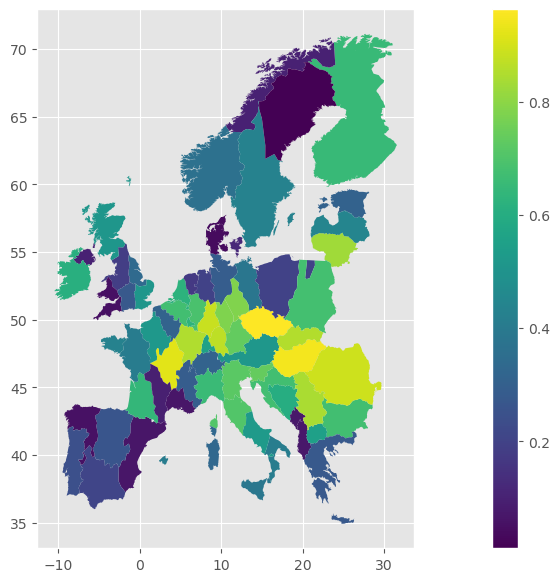

egs_mode                                             dh               \
egs_op                                           static         flex   
location                                                               
AL1 0    dac                                  22.310998    27.288587   
         geothermal generation share           0.000181     0.008956   
         geothermal heat chp district heat     0.000000     0.000000   
         geothermal heat chp elec              0.000000     0.000000   
         geothermal heat dh                    0.037401     2.997847   
...                                                 ...          ...   
SK1 0    geothermal heat chp district heat     0.000000     0.000000   
         geothermal heat chp elec              0.000000     0.000000   
         geothermal heat dh                 1789.534604  1820.798346   
         onwind                                0.141757     0.141757   
         solar                                 0.122296     0.12

In [160]:
import geopandas as gpd
shapes = gpd.read_file(Path.cwd().parent.parent.parent / "cluster_data" / "resources" / "regions_onshore_elec_s_72.geojson")
shapes = shapes.set_index("name")
shapes["diff"] = diff
mode = "chp"
# quant = "geothermal heat chp district heat"

quant = 'geothermal generation share'
diff = df.loc[idx[:, quant], idx[mode, "flex"]]#  - df.loc[idx[:, quant], idx[mode, "static"]]
diff.index = diff.index.get_level_values(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

print(shapes)
shapes.plot(column="diff", ax=ax, legend=True)
plt.show()

print(df)
